In [1]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/projects/ae-vae-anomaly-detection/data/processed/cleaned.csv'

Mounted at /content/drive


In [2]:
!mkdir -p /content/src/models

In [29]:
import sys
sys.path.append('/content/src')

from models.vae_model import VAE, KLAnnealing, train_vae, plot_vae_history
from models.beta_vae_model import BetaVAE

In [9]:
import pandas as pd

#load cleaned data
cleaned_df = pd.read_csv(data_path)
print(f'Loaded cleaned data: {cleaned_df.shape[0]} rows, {cleaned_df.shape[1]} columns')

# get a small sample for training model
df = cleaned_df.sample(frac=1, random_state=42)
print(f'Sampled data: {df.shape[0]} rows, {df.shape[1]} columns')

Loaded cleaned data: 640788 rows, 178 columns
Sampled data: 640788 rows, 178 columns


In [10]:
from sklearn.model_selection import train_test_split

# 1. Separate features and label
X = df.drop(columns='label')
y = df['label']

# 2. First split off a mixed test set (normal+anomaly), stratified to keep the same
#    anomaly ratio in train and test.
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 3. From the remaining (X_temp / y_temp) we only train on the normal samples:
#    i.e. drop the anomalies from this “train+val pool”
X_train_val = X_temp[y_temp == 0]

# 4. Finally split that normal‐only pool into X_train / X_val
X_train, X_val = train_test_split(
    X_train_val,
    test_size=0.2,
    random_state=42
)

# Now:
#  - X_train, X_val are both *only* normal samples (for AE/VAE training & early stopping)
#  - X_test / y_test is your held‐out mixed set (with both normal and anomalous),
#    and it never overlaps with X_train or X_val

Epoch 1/100
6249/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0119 - loss: 1.8056 - recon_loss: 1.7937

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - kl_loss: 0.0119 - loss: 1.8049 - recon_loss: 1.7930 - val_kl_loss: 0.0025 - val_loss: 1.5045 - val_recon_loss: 1.5020 - learning_rate: 0.0010
Epoch 2/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0740 - loss: 1.4859 - recon_loss: 1.4119

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 0.0740 - loss: 1.4859 - recon_loss: 1.4119 - val_kl_loss: 0.2697 - val_loss: 1.4447 - val_recon_loss: 1.1750 - learning_rate: 0.0010
Epoch 3/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.2664 - loss: 1.4488 - recon_loss: 1.1823

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 0.2664 - loss: 1.4488 - recon_loss: 1.1823 - val_kl_loss: 0.2762 - val_loss: 1.4445 - val_recon_loss: 1.1683 - learning_rate: 0.0010
Epoch 4/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 0.2672 - loss: 1.4453 - recon_loss: 1.1781 - val_kl_loss: 0.2629 - val_loss: 1.4472 - val_recon_loss: 1.1842 - learning_rate: 0.0010
Epoch 5/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - kl_loss: 0.2728 - loss: 1.4453 - recon_loss: 1.1725 - val_kl_loss: 0.2789 - val_loss: 1.4509 - val_recon_loss: 1.1719 - learning_rate: 0.0010
Epoch 6/100
6253/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.2711 - loss: 1.4425 - recon_loss: 1.1714
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - kl_loss: 0.2711 - loss: 1.4425 - recon_loss: 1.1714 - val_kl_loss: 0.2879 - val_loss: 1.4498 - val_recon_loss: 1.1619 - learning_rate: 0.0010
Epoch 7/100
6266/6266 ━━━━━━━━━━━━━━━━━

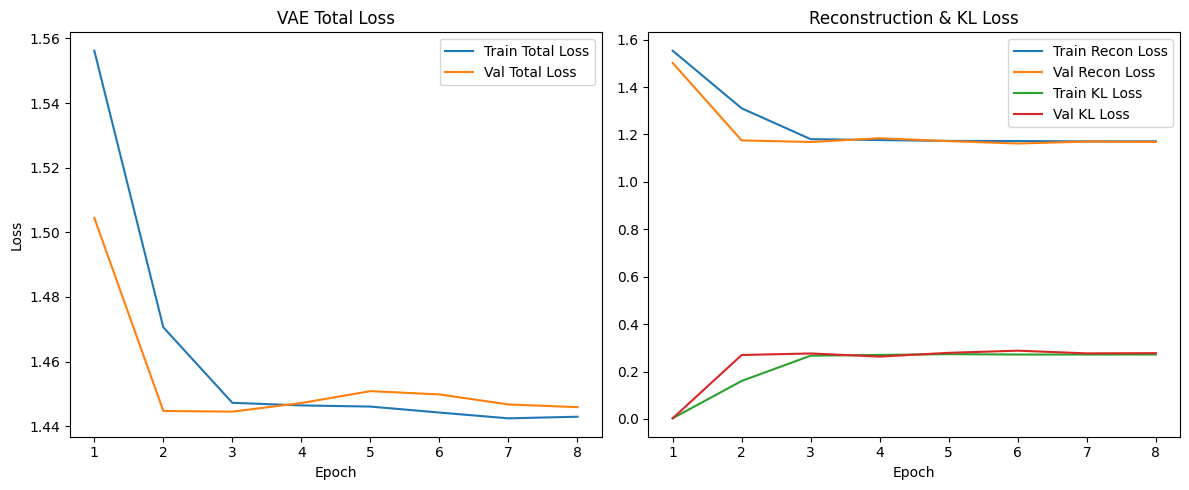

✅ VAE loss plot saved to vae_training_plot.png


In [11]:
#basic VAE
vae = VAE(input_dim=X_train.shape[1], encoding_dim=16)

history_vae, best_vae = train_vae(
    model=vae,
    X_train=X_train,
    X_val=X_val,
    save_path='best_vae.h5'
)
plot_vae_history(history_vae, save_path='vae_training_plot.png')

In [12]:
from models.ae_evaluation import evaluate_anomaly_detection, visualize_reconstruction, compute_reconstruction_error
vae_error = compute_reconstruction_error(best_vae, X_test)
evaluate_anomaly_detection(vae_error, y_test)

4005/4005 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


{'threshold': np.float64(0.01670657574113519),
 'precision': np.float64(0.2683478260869565),
 'recall': np.float64(0.540266106442577),
 'f1': np.float64(0.3585870322586984),
 'roc_auc': np.float64(0.9250053495404962),
 'confusion_matrix': {'TP': np.int64(1543),
  'FP': np.int64(4207),
  'TN': np.int64(121095),
  'FN': np.int64(1313)}}

Epoch 1/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0014 - loss: 1.7342 - recon_loss: 1.7203

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - kl_loss: 0.0014 - loss: 1.7339 - recon_loss: 1.7200 - val_kl_loss: 9.8071e-08 - val_loss: 1.4992 - val_recon_loss: 1.4992 - learning_rate: 0.0010
Epoch 2/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - kl_loss: 4.9192e-08 - loss: 1.4989 - recon_loss: 1.4989 - val_kl_loss: 1.1921e-07 - val_loss: 1.5014 - val_recon_loss: 1.5014 - learning_rate: 0.0010
Epoch 3/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 2.0007e-08 - loss: 1.4999 - recon_loss: 1.4999

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - kl_loss: 2.0006e-08 - loss: 1.4999 - recon_loss: 1.4999 - val_kl_loss: 0.0000e+00 - val_loss: 1.4987 - val_recon_loss: 1.4987 - learning_rate: 0.0010
Epoch 4/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 8.3553e-09 - loss: 1.4996 - recon_loss: 1.4996

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - kl_loss: 8.3556e-09 - loss: 1.4996 - recon_loss: 1.4996 - val_kl_loss: 0.0000e+00 - val_loss: 1.4985 - val_recon_loss: 1.4985 - learning_rate: 0.0010
Epoch 5/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 1.2002e-08 - loss: 1.5004 - recon_loss: 1.5004

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - kl_loss: 1.1999e-08 - loss: 1.5004 - recon_loss: 1.5004 - val_kl_loss: 0.0000e+00 - val_loss: 1.4984 - val_recon_loss: 1.4984 - learning_rate: 0.0010
Epoch 6/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 6.7661e-09 - loss: 1.5010 - recon_loss: 1.5010

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 6.7706e-09 - loss: 1.5010 - recon_loss: 1.5010 - val_kl_loss: 2.9802e-08 - val_loss: 1.4981 - val_recon_loss: 1.4981 - learning_rate: 0.0010
Epoch 7/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - kl_loss: 2.5782e-09 - loss: 1.4991 - recon_loss: 1.4991 - val_kl_loss: 0.0000e+00 - val_loss: 1.4987 - val_recon_loss: 1.4987 - learning_rate: 0.0010
Epoch 8/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 7.7836e-10 - loss: 1.4967 - recon_loss: 1.4967

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - kl_loss: 7.8057e-10 - loss: 1.4967 - recon_loss: 1.4967 - val_kl_loss: 0.0000e+00 - val_loss: 1.4981 - val_recon_loss: 1.4981 - learning_rate: 0.0010
Epoch 9/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 3.0714e-09 - loss: 1.4982 - recon_loss: 1.4982
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - kl_loss: 3.0711e-09 - loss: 1.4982 - recon_loss: 1.4982 - val_kl_loss: 0.0000e+00 - val_loss: 1.4981 - val_recon_loss: 1.4981 - learning_rate: 0.0010
Epoch 10/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 1.1242e-11 - loss: 1.4984 - recon_loss: 1.4984

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - kl_loss: 1.1259e-11 - loss: 1.4984 - recon_loss: 1.4984 - val_kl_loss: 0.0000e+00 - val_loss: 1.4980 - val_recon_loss: 1.4980 - learning_rate: 5.0000e-04
Epoch 11/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 7.3150e-12 - loss: 1.4985 - recon_loss: 1.4985 - val_kl_loss: 0.0000e+00 - val_loss: 1.4980 - val_recon_loss: 1.4980 - learning_rate: 5.0000e-04
Epoch 12/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4990 - recon_loss: 1.4990 - val_kl_loss: 0.0000e+00 - val_loss: 1.4980 - val_recon_loss: 1.4980 - learning_rate: 5.0000e-04
Epoch 13/100
6250/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.5014 - recon_loss: 1.5014

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.5014 - recon_loss: 1.5014 - val_kl_loss: 0.0000e+00 - val_loss: 1.4979 - val_recon_loss: 1.4979 - learning_rate: 5.0000e-04
Epoch 14/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.4996 - recon_loss: 1.4996 - val_kl_loss: 0.0000e+00 - val_loss: 1.4979 - val_recon_loss: 1.4979 - learning_rate: 5.0000e-04
Epoch 15/100
6256/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4972 - recon_loss: 1.4972

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.4972 - recon_loss: 1.4972 - val_kl_loss: 2.9802e-08 - val_loss: 1.4978 - val_recon_loss: 1.4978 - learning_rate: 5.0000e-04
Epoch 16/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 2.4055e-10 - loss: 1.4980 - recon_loss: 1.4980
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - kl_loss: 2.4063e-10 - loss: 1.4980 - recon_loss: 1.4980 - val_kl_loss: 0.0000e+00 - val_loss: 1.4979 - val_recon_loss: 1.4979 - learning_rate: 5.0000e-04
Epoch 17/100
6260/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4987 - recon_loss: 1.4987

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4987 - recon_loss: 1.4987 - val_kl_loss: 0.0000e+00 - val_loss: 1.4978 - val_recon_loss: 1.4978 - learning_rate: 2.5000e-04
Epoch 18/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4997 - recon_loss: 1.4997 - val_kl_loss: 0.0000e+00 - val_loss: 1.4978 - val_recon_loss: 1.4978 - learning_rate: 2.5000e-04
Epoch 19/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.4978 - recon_loss: 1.4978 - val_kl_loss: 0.0000e+00 - val_loss: 1.4979 - val_recon_loss: 1.4979 - learning_rate: 2.5000e-04
Epoch 20/100
6263/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4981 - recon_loss: 1.4981
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.4981 - recon_loss: 1.4981 - val_kl_loss: 0.0000e+00 - val_loss: 1.4979 - val_recon_loss: 1.4979 - learning_

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.4988 - recon_loss: 1.4988 - val_kl_loss: 0.0000e+00 - val_loss: 1.4978 - val_recon_loss: 1.4978 - learning_rate: 1.2500e-04
Epoch 22/100
6254/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.5004 - recon_loss: 1.5004

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.5004 - recon_loss: 1.5004 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 1.2500e-04
Epoch 23/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4991 - recon_loss: 1.4991
Epoch 23: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.4991 - recon_loss: 1.4991 - val_kl_loss: 0.0000e+00 - val_loss: 1.4978 - val_recon_loss: 1.4978 - learning_rate: 1.2500e-04
Epoch 24/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4971 - recon_loss: 1.4971

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.4971 - recon_loss: 1.4971 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 6.2500e-05
Epoch 25/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.5000 - recon_loss: 1.5000 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 6.2500e-05
Epoch 26/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4992 - recon_loss: 1.4992


Epoch 26: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4992 - recon_loss: 1.4992 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 6.2500e-05
Epoch 27/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4996 - recon_loss: 1.4996 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 3.1250e-05
Epoch 28/100
6254/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4973 - recon_loss: 1.4973

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4973 - recon_loss: 1.4973 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 3.1250e-05
Epoch 29/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4988 - recon_loss: 1.4988
Epoch 29: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4988 - recon_loss: 1.4988 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 3.1250e-05
Epoch 30/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4976 - recon_loss: 1.4976 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 1.5625e-05
Epoch 31/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.4980 - recon_loss: 1.4980 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning


Epoch 32: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 0.0000e+00 - loss: 1.5001 - recon_loss: 1.5001 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 1.5625e-05
Epoch 33/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4984 - recon_loss: 1.4984 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 7.8125e-06
Epoch 34/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4971 - recon_loss: 1.4971 - val_kl_loss: 0.0000e+00 - val_loss: 1.4977 - val_recon_loss: 1.4977 - learning_rate: 7.8125e-06
Epoch 35/100
6251/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4985 - recon_loss: 1.4985
Epoch 35: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - kl_loss: 0.0000e+00 - loss: 1.4986 - recon_loss: 1.4986 - v

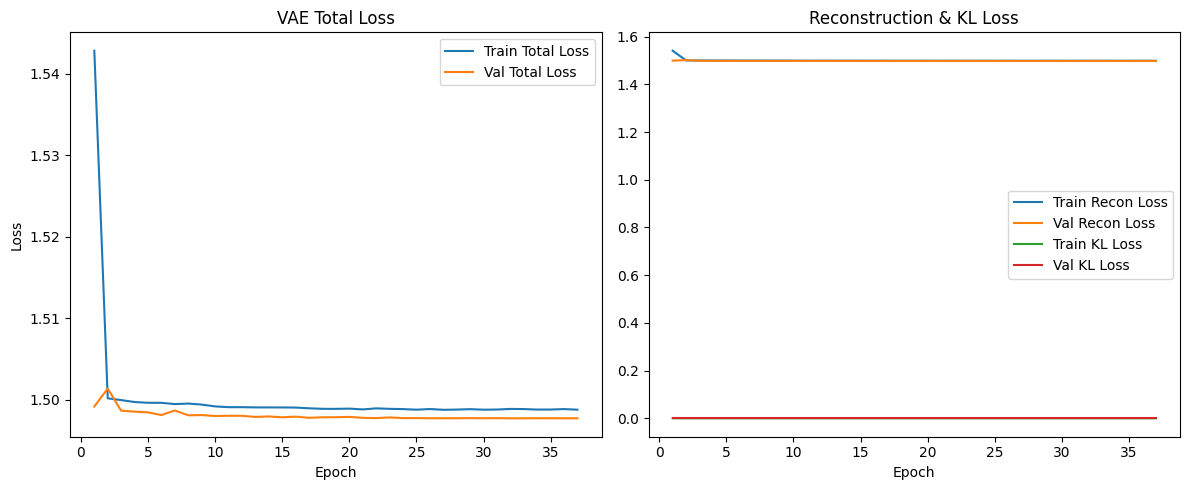

✅ VAE loss plot saved to beta_vae_training_plot.png


In [16]:
#Beta VAE
Beta_vae = BetaVAE(input_dim=X_train.shape[1], encoding_dim=16, beta=10.0)
history_beta_vae, best_beta_vae = train_vae(
    model=Beta_vae,
    X_train=X_train,
    X_val=X_val,
    save_path='best_beta_vae.h5'
)
plot_vae_history(history_beta_vae, save_path='beta_vae_training_plot.png')

In [17]:
beta_vae_error = compute_reconstruction_error(best_beta_vae, X_test)
evaluate_anomaly_detection(beta_vae_error, y_test)

4005/4005 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


{'threshold': np.float64(0.015811181650599398),
 'precision': np.float64(0.48454845484548453),
 'recall': np.float64(0.5654761904761905),
 'f1': np.float64(0.5218936822899318),
 'roc_auc': np.float64(0.902710005008851),
 'confusion_matrix': {'TP': np.int64(1615),
  'FP': np.int64(1718),
  'TN': np.int64(123584),
  'FN': np.int64(1241)}}

In [33]:
#Beta VAE with KL method
vae = VAE(input_dim=X_train.shape[1], encoding_dim=16)
kl_scheduler = KLAnnealing(start_beta=0.0, target_beta=4.0, n_epochs=10)
history, model = train_vae(vae, X_train, X_val, kl_scheduler=kl_scheduler)


Epoch 1/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 176.0680 - loss: 0.5668 - recon_loss: 0.5668

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - kl_loss: 176.1249 - loss: 0.5663 - recon_loss: 0.5663 - val_kl_loss: 217.0902 - val_loss: 0.0263 - val_recon_loss: 0.0263 - learning_rate: 0.0010
Epoch 2/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 209.8904 - loss: 0.0225 - recon_loss: 0.0225

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 209.8825 - loss: 0.0225 - recon_loss: 0.0225 - val_kl_loss: 192.8410 - val_loss: 0.0178 - val_recon_loss: 0.0178 - learning_rate: 0.0010
Epoch 3/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 192.0695 - loss: 0.0170 - recon_loss: 0.0170

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - kl_loss: 192.0694 - loss: 0.0170 - recon_loss: 0.0170 - val_kl_loss: 190.0154 - val_loss: 0.0139 - val_recon_loss: 0.0139 - learning_rate: 0.0010
Epoch 4/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 191.4885 - loss: 0.0139 - recon_loss: 0.0139

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - kl_loss: 191.4893 - loss: 0.0139 - recon_loss: 0.0139 - val_kl_loss: 199.2867 - val_loss: 0.0109 - val_recon_loss: 0.0109 - learning_rate: 0.0010
Epoch 5/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 197.9743 - loss: 0.0106 - recon_loss: 0.0106

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - kl_loss: 197.9722 - loss: 0.0106 - recon_loss: 0.0106 - val_kl_loss: 193.3284 - val_loss: 0.0106 - val_recon_loss: 0.0106 - learning_rate: 0.0010
Epoch 6/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 192.6865 - loss: 0.0097 - recon_loss: 0.0097 - val_kl_loss: 191.1760 - val_loss: 0.0116 - val_recon_loss: 0.0116 - learning_rate: 0.0010
Epoch 7/100
6260/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 191.5585 - loss: 0.0093 - recon_loss: 0.0093

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - kl_loss: 191.5583 - loss: 0.0093 - recon_loss: 0.0093 - val_kl_loss: 189.7238 - val_loss: 0.0097 - val_recon_loss: 0.0097 - learning_rate: 0.0010
Epoch 8/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 191.0755 - loss: 0.0087 - recon_loss: 0.0087

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - kl_loss: 191.0755 - loss: 0.0087 - recon_loss: 0.0087 - val_kl_loss: 191.0321 - val_loss: 0.0087 - val_recon_loss: 0.0087 - learning_rate: 0.0010
Epoch 9/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 190.1818 - loss: 0.0084 - recon_loss: 0.0084 - val_kl_loss: 190.5914 - val_loss: 0.0087 - val_recon_loss: 0.0087 - learning_rate: 0.0010
Epoch 10/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - kl_loss: 191.5314 - loss: 0.0081 - recon_loss: 0.0081 - val_kl_loss: 191.4169 - val_loss: 0.0140 - val_recon_loss: 0.0140 - learning_rate: 0.0010
Epoch 11/100
6261/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 190.4373 - loss: 0.0080 - recon_loss: 0.0080

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 190.4389 - loss: 0.0080 - recon_loss: 0.0080 - val_kl_loss: 194.0742 - val_loss: 0.0076 - val_recon_loss: 0.0076 - learning_rate: 0.0010
Epoch 12/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - kl_loss: 194.4365 - loss: 0.0077 - recon_loss: 0.0077 - val_kl_loss: 196.0135 - val_loss: 0.0077 - val_recon_loss: 0.0077 - learning_rate: 0.0010
Epoch 13/100
6263/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 199.0342 - loss: 0.0072 - recon_loss: 0.0072

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - kl_loss: 199.0357 - loss: 0.0072 - recon_loss: 0.0072 - val_kl_loss: 205.8727 - val_loss: 0.0076 - val_recon_loss: 0.0076 - learning_rate: 0.0010
Epoch 14/100
6261/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 204.9824 - loss: 0.0062 - recon_loss: 0.0062

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 204.9821 - loss: 0.0062 - recon_loss: 0.0062 - val_kl_loss: 204.5009 - val_loss: 0.0073 - val_recon_loss: 0.0073 - learning_rate: 0.0010
Epoch 15/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 202.7427 - loss: 0.0060 - recon_loss: 0.0060

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - kl_loss: 202.7421 - loss: 0.0060 - recon_loss: 0.0060 - val_kl_loss: 199.5794 - val_loss: 0.0066 - val_recon_loss: 0.0066 - learning_rate: 0.0010
Epoch 16/100
6255/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 200.4481 - loss: 0.0057 - recon_loss: 0.0057

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 200.4478 - loss: 0.0057 - recon_loss: 0.0057 - val_kl_loss: 198.2620 - val_loss: 0.0060 - val_recon_loss: 0.0060 - learning_rate: 0.0010
Epoch 17/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 199.5775 - loss: 0.0056 - recon_loss: 0.0056

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - kl_loss: 199.5775 - loss: 0.0056 - recon_loss: 0.0056 - val_kl_loss: 199.5098 - val_loss: 0.0055 - val_recon_loss: 0.0055 - learning_rate: 0.0010
Epoch 18/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - kl_loss: 199.8178 - loss: 0.0054 - recon_loss: 0.0054 - val_kl_loss: 200.5392 - val_loss: 0.0067 - val_recon_loss: 0.0067 - learning_rate: 0.0010
Epoch 19/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 200.0089 - loss: 0.0053 - recon_loss: 0.0053

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - kl_loss: 200.0091 - loss: 0.0053 - recon_loss: 0.0053 - val_kl_loss: 201.9533 - val_loss: 0.0053 - val_recon_loss: 0.0053 - learning_rate: 0.0010
Epoch 20/100
6261/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 202.2065 - loss: 0.0051 - recon_loss: 0.0051

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 202.2074 - loss: 0.0051 - recon_loss: 0.0051 - val_kl_loss: 203.7853 - val_loss: 0.0051 - val_recon_loss: 0.0051 - learning_rate: 0.0010
Epoch 21/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - kl_loss: 202.8887 - loss: 0.0051 - recon_loss: 0.0051 - val_kl_loss: 203.6045 - val_loss: 0.0052 - val_recon_loss: 0.0052 - learning_rate: 0.0010
Epoch 22/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 203.8517 - loss: 0.0050 - recon_loss: 0.0050

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - kl_loss: 203.8515 - loss: 0.0050 - recon_loss: 0.0050 - val_kl_loss: 205.2345 - val_loss: 0.0050 - val_recon_loss: 0.0050 - learning_rate: 0.0010
Epoch 23/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 204.3104 - loss: 0.0049 - recon_loss: 0.0049
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - kl_loss: 204.3109 - loss: 0.0049 - recon_loss: 0.0049 - val_kl_loss: 206.4309 - val_loss: 0.0055 - val_recon_loss: 0.0055 - learning_rate: 0.0010
Epoch 24/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 210.2194 - loss: 0.0046 - recon_loss: 0.0046

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - kl_loss: 210.2200 - loss: 0.0046 - recon_loss: 0.0046 - val_kl_loss: 213.4285 - val_loss: 0.0048 - val_recon_loss: 0.0048 - learning_rate: 5.0000e-04
Epoch 25/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - kl_loss: 213.2270 - loss: 0.0046 - recon_loss: 0.0046 - val_kl_loss: 214.2364 - val_loss: 0.0051 - val_recon_loss: 0.0051 - learning_rate: 5.0000e-04
Epoch 26/100
6260/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 214.3855 - loss: 0.0046 - recon_loss: 0.0046

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - kl_loss: 214.3860 - loss: 0.0046 - recon_loss: 0.0046 - val_kl_loss: 215.7834 - val_loss: 0.0047 - val_recon_loss: 0.0047 - learning_rate: 5.0000e-04
Epoch 27/100
6260/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 216.3010 - loss: 0.0046 - recon_loss: 0.0046


Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 216.3012 - loss: 0.0046 - recon_loss: 0.0046 - val_kl_loss: 218.2963 - val_loss: 0.0047 - val_recon_loss: 0.0047 - learning_rate: 5.0000e-04
Epoch 28/100
6257/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 219.3966 - loss: 0.0045 - recon_loss: 0.0045

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 219.3982 - loss: 0.0045 - recon_loss: 0.0045 - val_kl_loss: 221.3923 - val_loss: 0.0045 - val_recon_loss: 0.0045 - learning_rate: 2.5000e-04
Epoch 29/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - kl_loss: 221.9988 - loss: 0.0044 - recon_loss: 0.0044 - val_kl_loss: 224.9266 - val_loss: 0.0046 - val_recon_loss: 0.0046 - learning_rate: 2.5000e-04
Epoch 30/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 224.2922 - loss: 0.0044 - recon_loss: 0.0044 - val_kl_loss: 225.9615 - val_loss: 0.0047 - val_recon_loss: 0.0047 - learning_rate: 2.5000e-04
Epoch 31/100
6257/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 225.7927 - loss: 0.0044 - recon_loss: 0.0044


Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - kl_loss: 225.7931 - loss: 0.0044 - recon_loss: 0.0044 - val_kl_loss: 226.2184 - val_loss: 0.0045 - val_recon_loss: 0.0045 - learning_rate: 2.5000e-04
Epoch 32/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 227.1540 - loss: 0.0044 - recon_loss: 0.0044

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - kl_loss: 227.1544 - loss: 0.0044 - recon_loss: 0.0044 - val_kl_loss: 230.0520 - val_loss: 0.0044 - val_recon_loss: 0.0044 - learning_rate: 1.2500e-04
Epoch 33/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 229.9741 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 231.1849 - val_loss: 0.0044 - val_recon_loss: 0.0044 - learning_rate: 1.2500e-04
Epoch 34/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 231.4944 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - kl_loss: 231.4944 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 232.7323 - val_loss: 0.0044 - val_recon_loss: 0.0044 - learning_rate: 1.2500e-04
Epoch 35/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 232.6630 - loss: 0.0043 - recon_loss: 0.0043
Epoch 35: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - kl_loss: 232.6630 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 233.6338 - val_loss: 0.0044 - val_recon_loss: 0.0044 - learning_rate: 1.2500e-04
Epoch 36/100
6261/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 233.6819 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 233.6823 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 234.9507 - val_loss: 0.0044 - val_recon_loss: 0.0044 - learning_rate: 6.2500e-05
Epoch 37/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - kl_loss: 235.1049 - loss: 0.0044 - recon_loss: 0.0044 - val_kl_loss: 235.8804 - val_loss: 0.0044 - val_recon_loss: 0.0044 - learning_rate: 6.2500e-05
Epoch 38/100
6257/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 235.7739 - loss: 0.0043 - recon_loss: 0.0043


Epoch 38: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 235.7745 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 236.9730 - val_loss: 0.0044 - val_recon_loss: 0.0044 - learning_rate: 6.2500e-05
Epoch 39/100
6263/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 236.8792 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - kl_loss: 236.8793 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 237.8463 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 3.1250e-05
Epoch 40/100
6261/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 237.5592 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 237.5594 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 238.5745 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 3.1250e-05
Epoch 41/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 238.2607 - loss: 0.0043 - recon_loss: 0.0043


Epoch 41: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - kl_loss: 238.2608 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 239.0187 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 3.1250e-05
Epoch 42/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 238.7487 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 238.7492 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 239.5804 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.5625e-05
Epoch 43/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 239.3447 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 240.0764 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.5625e-05
Epoch 44/100
6256/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 239.7285 - loss: 0.0042 - recon_loss: 0.0042


Epoch 44: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 239.7289 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 240.4596 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.5625e-05
Epoch 45/100
6253/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 240.1918 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - kl_loss: 240.1920 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 240.7266 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 7.8125e-06
Epoch 46/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 240.4167 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 240.8842 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 7.8125e-06
Epoch 47/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 240.7301 - loss: 0.0042 - recon_loss: 0.0042


Epoch 47: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - kl_loss: 240.7301 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.2404 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 7.8125e-06
Epoch 48/100
6263/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 240.9412 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - kl_loss: 240.9412 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 241.2950 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 3.9063e-06
Epoch 49/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 240.9173 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - kl_loss: 240.9174 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.3861 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 3.9063e-06
Epoch 50/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.1561 - loss: 0.0042 - recon_loss: 0.0042


Epoch 50: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - kl_loss: 241.1561 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.5042 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 3.9063e-06
Epoch 51/100
6254/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 241.2963 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - kl_loss: 241.2962 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.5697 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.9531e-06
Epoch 52/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.4077 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - kl_loss: 241.4076 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.5865 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.9531e-06
Epoch 53/100
6256/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.2663 - loss: 0.0042 - recon_loss: 0.0042


Epoch 53: ReduceLROnPlateau reducing learning rate to 1e-06.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 241.2665 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.6911 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.9531e-06
Epoch 54/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.3772 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - kl_loss: 241.3773 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 241.7305 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 55/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.5008 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - kl_loss: 241.5007 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.7713 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 56/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - kl_loss: 241.4017 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.7913 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 57/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.4162 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 241.4163 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.8289 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 58/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.5085 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 241.5085 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.8156 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 59/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.6764 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 241.6764 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 241.8716 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 60/100
6256/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.4217 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 241.4220 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.9262 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 61/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - kl_loss: 241.5859 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 241.9435 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 62/100
6256/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.7756 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 241.7755 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 241.9811 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 63/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 241.6864 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 241.9884 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 64/100
6256/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.8376 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - kl_loss: 241.8374 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 242.0222 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 65/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.6551 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 241.6552 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.0629 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 66/100
6254/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.8071 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 241.8071 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.0710 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 67/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.5830 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - kl_loss: 241.5833 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.1135 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 68/100
6263/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.9312 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - kl_loss: 241.9312 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 242.1542 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 69/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - kl_loss: 241.8019 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.1709 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 70/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - kl_loss: 241.9263 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.1826 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 71/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.8790 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 241.8790 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 242.2328 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 72/100
6261/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.9787 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - kl_loss: 241.9787 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.2611 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 73/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 242.0356 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.2915 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 74/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 242.0989 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 242.3055 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 75/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.1395 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - kl_loss: 242.1393 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.3428 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 76/100
6261/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 241.9191 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - kl_loss: 241.9192 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.3512 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 77/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.1452 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 242.1451 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.3809 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 78/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 242.1497 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.4151 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 79/100
6254/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.0642 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 242.0644 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.4407 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 80/100
6254/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.2076 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - kl_loss: 242.2075 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.4658 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 81/100
6255/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.1600 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - kl_loss: 242.1601 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.5074 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 82/100
6261/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.0956 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 242.0958 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.5215 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 83/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 242.1834 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 242.5385 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 84/100
6252/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.1670 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - kl_loss: 242.1673 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.5644 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 85/100
6257/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.5018 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 242.5015 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.6054 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 86/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.3517 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 242.3517 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.6243 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 87/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.3631 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - kl_loss: 242.3631 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.6536 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 88/100
6263/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.3114 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - kl_loss: 242.3114 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.6780 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 89/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - kl_loss: 242.4671 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.6980 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 90/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - kl_loss: 242.3696 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.7466 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 91/100
6263/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.6397 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - kl_loss: 242.6396 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.7830 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 92/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - kl_loss: 242.5620 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.7761 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 93/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.5920 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - kl_loss: 242.5919 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.8060 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 94/100
6256/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.5568 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - kl_loss: 242.5567 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.8406 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 95/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 242.5912 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.8701 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 96/100
6261/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.5095 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - kl_loss: 242.5095 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.8896 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 97/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.5127 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - kl_loss: 242.5128 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.9218 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 98/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.6823 - loss: 0.0042 - recon_loss: 0.0042

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - kl_loss: 242.6823 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.9461 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 99/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - kl_loss: 242.6637 - loss: 0.0042 - recon_loss: 0.0042 - val_kl_loss: 242.9488 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06
Epoch 100/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 242.6567 - loss: 0.0043 - recon_loss: 0.0043

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - kl_loss: 242.6567 - loss: 0.0043 - recon_loss: 0.0043 - val_kl_loss: 243.0059 - val_loss: 0.0043 - val_recon_loss: 0.0043 - learning_rate: 1.0000e-06


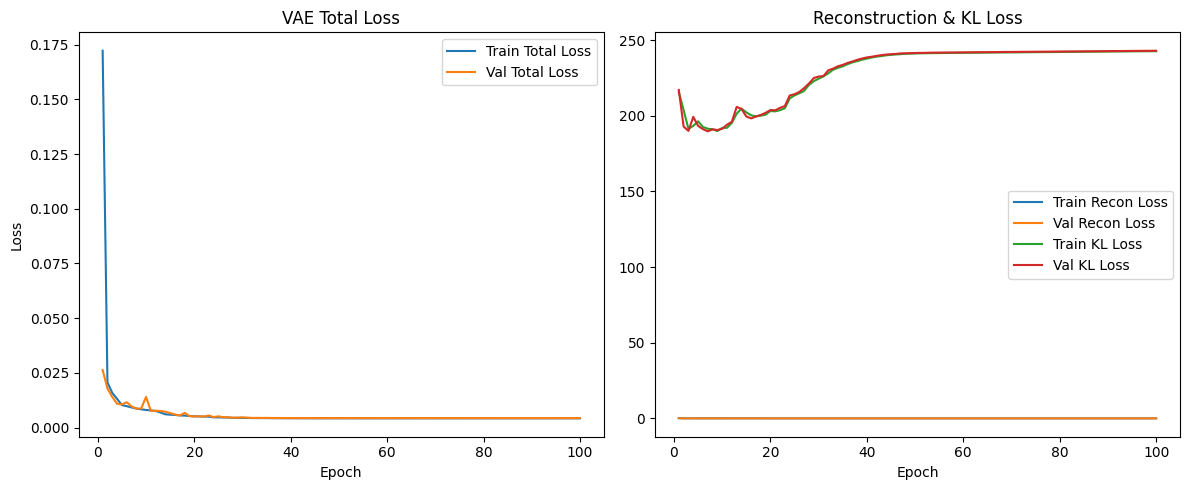

✅ VAE loss 曲线已保存到 beta_K_vae_training_plot.png


In [34]:
plot_vae_history(history, save_path='beta_K_vae_training_plot.png')

In [35]:
beta_K_vae_error = compute_reconstruction_error(model, X_test)
evaluate_anomaly_detection(beta_K_vae_error, y_test)

4005/4005 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


{'threshold': np.float64(0.000587772142313846),
 'precision': np.float64(0.8308026030368764),
 'recall': np.float64(0.4023109243697479),
 'f1': np.float64(0.5421089879248979),
 'roc_auc': np.float64(0.8939045646670025),
 'confusion_matrix': {'TP': np.int64(1149),
  'FP': np.int64(234),
  'TN': np.int64(125068),
  'FN': np.int64(1707)}}